In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup constant head boundary with two observations

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.boundaries.RiverObservation import ObservationId, Conductance, RiverObservationValue, RiverStage, \
  RiverbedBottom, RiverObservation
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection, RiverBoundary
from morpheus.project.types.layers import LayerId

layers_list = [LayerId.new()]

river_boundary = RiverBoundary.from_geometry(
  name=BoundaryName('river'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92499, 50.966),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    RiverObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          riverbed_bottom=RiverbedBottom.from_float(100),
          river_stage=RiverStage.from_float(105),
          conductance=Conductance.from_float(50),
        ),
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          riverbed_bottom=RiverbedBottom.from_float(100),
          river_stage=RiverStage.from_float(105),
          conductance=Conductance.from_float(50),
        ),
      ]
    ),
    RiverObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96401)),
      data=[
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          riverbed_bottom=RiverbedBottom.from_float(95),
          river_stage=RiverStage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        RiverObservationValue(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          riverbed_bottom=RiverbedBottom.from_float(95),
          river_stage=RiverStage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(river_boundary)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(river_boundary.as_geojson()))
for observation in river_boundary.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.fit_bounds(m.get_bounds())
m

In [7]:
river_boundary.observations

[RiverObservation(observation_id=ObservationId(value='e7e5b99e-6594-43da-955b-310cc4253f21'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), data=[RiverObservationValue(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), river_stage=RiverStage(value=105), riverbed_bottom=RiverbedBottom(value=100), conductance=Conductance(value=50)), RiverObservationValue(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), river_stage=RiverStage(value=105), riverbed_bottom=RiverbedBottom(value=100), conductance=Conductance(value=50))]),
 RiverObservation(observation_id=ObservationId(value='d8fee7c4-9a33-4e92-aaa1-1851454270b1'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92004, 50.96401), type='Point'), data=[RiverObservationValue(date_time=StartDateTime(value=datetime.datetime(2019, 

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.RivPackageMapper import \
  calculate_riv_boundary_stress_period_data

result = calculate_riv_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  riv_boundary=river_boundary,
)
result.to_dict()

{0: [[0, 0, 98, 104.93648697732888, 50.6351302267112, 99.93648697732888],
  [0, 0, 99, 104.97996508544105, 50.200349145589506, 99.97996508544105],
  [0, 1, 96, 104.83554778781311, 51.644522121868825, 99.83554778781311],
  [0, 1, 97, 104.87902589592683, 51.209741040731686, 99.87902589592683],
  [0, 2, 94, 104.73460858626737, 52.65391413732636, 99.73460858626737],
  [0, 2, 95, 104.77808669438107, 52.21913305618921, 99.77808669438107],
  [0, 3, 92, 104.63366937267645, 53.66330627323551, 99.63366937267645],
  [0, 3, 93, 104.6771474807917, 53.22852519208293, 99.6771474807917],
  [0, 4, 90, 104.53273014704902, 54.6726985295097, 99.53273014704902],
  [0, 4, 91, 104.5762082551612, 54.237917448388, 99.5762082551612],
  [0, 5, 88, 104.43179090937893, 55.68209090621068, 99.43179090937893],
  [0, 5, 89, 104.47526901749265, 55.247309825073536, 99.47526901749265],
  [0, 6, 86, 104.3308516596683, 56.69148340331698, 99.3308516596683],
  [0, 6, 87, 104.37432976778202, 56.256702322179834, 99.37432976778

## Calculate

In [9]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType

calculation = CalculationService.calculate(model=model, profile=CalculationProfile.new(CalculationEngineType.MF2005))

FloPy is using the following executable to run the model: ../../../../../../Users/ralf/Projects/inowas/morpheus/src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/08/21 22:30:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/08/21 22:30:23
 Elapsed run time:  0.031 Seconds

  Normal termination of simulation


In [10]:
calculation.check_model_log

Log(log=['type,package,k,i,j,value,desc'])

In [11]:
calculation.calculation_result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['mf2005.list', 'mf2005.dis', 'mf2005.nam', 'mf2005.bas', 'mf2005.lpf', 'mf2005.pcg', 'mf2005.riv', 'mf2005.oc', 'mf2005.hds'], flow_head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0, min_value=100.00115203857422, max_value=104.97736358642578), flow_drawdown_results=None, flow_budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0, min_value=None, max_value=None), transport_concentration_results=None, transport_budget_results=None, packages=['DIS', 'BAS6', 'RIV', 'PCG', 'LPF', 'OC'])

In [12]:
head = calculation.read_flow_head(idx=0, layer=0)

In [13]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[101.82559967041016, 101.82640075683594, 101.8280029296875, 101.83039855957031, 101.83360290527344, 101.83760070800781, 101.84230041503906, 101.847900390625, 101.85420227050781, 101.86139678955078, 101.86930084228516, 101.87799835205078, 101.88749694824219, 101.89779663085938, 101.90879821777344, 101.92060089111328, 101.93319702148438, 101.94650268554688, 101.96060180664062, 101.97540283203125, 101.99099731445312, 102.00740051269531, 102.02439880371094, 102.04219818115234, 102.06079864501953, 102.08000183105469, 102.0999984741211, 102.12069702148438, 102.14209747314453, 102.16419982910156, 102.18699645996094, 102.21050262451172, 102.23470306396484, 102.2594985961914, 102.28500366210938, 102.31120300292969, 102.33799743652344, 102.3655014038086, 102.39360046386719, 102.42230224609375, 102.45169830322266, 102.48169708251953, 102.51229858398438, 102.54350280761719, 102.57530212402344, 102.60759735107422, 102.6406021118164, 102.67410278320312, 102.70819854736328, 102.7428970336914, 102.7

In [14]:
calculation.read_flow_drawdown(idx=0, layer=0)

[]

In [15]:
calculation.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'RIVER_LEAKAGE_IN': 857.8719,
 'TOTAL_IN': 857.8719,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'RIVER_LEAKAGE_OUT': -857.9005,
 'TOTAL_OUT': -857.9005,
 'IN-OUT': -0.028564,
 'PERCENT_DISCREPANCY': -0.0,
 'tslen': 365.0}

In [16]:
calculation.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'RIVER_LEAKAGE_IN': 2.3503,
 'TOTAL_IN': 2.3503,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'RIVER_LEAKAGE_OUT': -2.3504,
 'TOTAL_OUT': -2.3504,
 'IN-OUT': -7.8201e-05,
 'PERCENT_DISCREPANCY': -0.0,
 'tslen': 365.0}

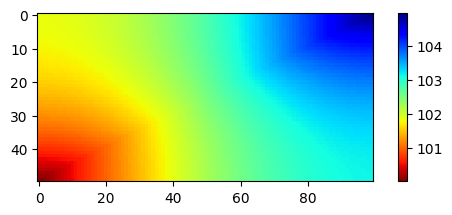

In [17]:
import matplotlib.pyplot as plt

heads = calculation.read_flow_head(idx=0, layer=0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()